In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class
from matplotlib.patches import Arc
import matplotlib.patheffects as path_effects
from IPython.display import display

In [8]:
def json_to_normalized_dataframe(path):
    rd = ""
    with open(path, 'r') as f:
        rd = f.read()
    obj = json.loads(rd)
    df = pd.json_normalize(obj)
    return df


In [9]:
def players_with_coordinates(df, x_list = [0,44,32,32,44,56,66,66,87,87,100], y_list = [45,10,35,55,80,45,25,65,15,75,45], home_team = True):
    team_dict = {}
    if home_team == True:
        for i in df["tactics.lineup"][0]:
            team_dict[i['player']['name']] = []
    else:
        for i in df["tactics.lineup"][1]:
            team_dict[i['player']['name']] = []

    for x,y,z in zip(x_list, y_list, team_dict):
        entry = {z:[x,y]}
        team_dict.update(entry)

    return team_dict


In [25]:
def Passer(player):
    local_df = df.copy(deep=True)
    local_df = local_df[local_df["type.name"] == "Pass"]
    local_df = local_df[local_df["player.name"] == player]
    local_df = local_df.dropna(axis=1, how="all")

    if "pass.outcome.name" not in local_df.columns:
        df1 = local_df[['pass.angle', 'pass.length']].copy()
        df1['pass.outcome.name'] = df['pass.angle'].apply(lambda x: np.nan)
    else:
        df1 = local_df[['pass.angle', 'pass.length', 'pass.outcome.name']].copy()
    
    bins = np.linspace(-np.pi, np.pi, 20)
    df1['binned'] = pd.cut(local_df['pass.angle'], bins,
                           include_lowest=True, right=True)
    df1["Bin_Mids"] = df1["binned"].apply(lambda x: x.mid)
    df1["Complete"] = df1["pass.outcome.name"].apply(
        lambda x: 1 if pd.isna(x) else 0)
    df1 = df1[:-1]

    A = df1.groupby("Bin_Mids", as_index=False, dropna=False).mean()
    A = A.dropna(axis=0)
    #A["Incomplete"] = 1-A["Complete"]

    return A


In [26]:

def plot_inset(width, axis_main, data, x,y):
    ax_sub= inset_axes(axis_main, width=width, height=width, loc=10,
                       bbox_to_anchor=(x,y),
                       bbox_transform=axis_main.transData,
                       borderpad=0.0, axes_class=get_projection_class("polar"))

    theta = data["Bin_Mids"]
    radii = data["pass.length"]
    color_metric = data["Complete"]
    bars = ax_sub.bar(theta, radii, width=0.3, bottom=0.0)
    ax_sub.patch.set_alpha(0)
    ax_sub.set_xticklabels([])
    ax_sub.set_yticks([])
    ax_sub.yaxis.grid(False)
    ax_sub.xaxis.grid(False)
    ax_sub.spines['polar'].set_visible(False)

    for r, bar in zip(color_metric, bars):
        bar.set_facecolor(plt.cm.viridis(r))
        bar.set_alpha(0.5)


In [30]:

def get_team_sonar(df, team_dict, x_list=[0, 44, 32, 32, 44, 56, 66, 66, 87, 87, 100], y_list=[45, 10, 35, 55, 80, 45, 25, 65, 15, 75, 45], width=.8, home: bool = True):
    fig, ax = plt.subplots(figsize=(10.5, 6.8), dpi=300)

    for player_name, loc in team_dict.items():
        plot_inset(width, ax, data=Passer(player_name), x=loc[0], y=loc[1])
        ax.text(loc[0]+8, loc[1], player_name, size=7, ha='left', va='center', rotation=-90, weight='bold', path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'),
                                                                                                                          path_effects.Normal()])

    ax.plot([0, 0], [0, 90], color="black")
    ax.plot([0, 130], [90, 90], color="black")
    ax.plot([130, 130], [90, 0], color="black")
    ax.plot([130, 0], [0, 0], color="black")
    ax.plot([65, 65], [0, 90], color="black")

    # Left Penalty Area
    ax.plot([16.5, 16.5], [65, 25], color="black")
    ax.plot([0, 16.5], [65, 65], color="black")
    ax.plot([16.5, 0], [25, 25], color="black")

    # Right Penalty Area
    ax.plot([130, 113.5], [65, 65], color="black")
    ax.plot([113.5, 113.5], [65, 25], color="black")
    ax.plot([113.5, 130], [25, 25], color="black")

    # Left 6-yard Box
    ax.plot([0, 5.5], [54, 54], color="black")
    ax.plot([5.5, 5.5], [54, 36], color="black")
    ax.plot([5.5, 0.5], [36, 36], color="black")

    # Right 6-yard Box
    ax.plot([130, 124.5], [54, 54], color="black")
    ax.plot([124.5, 124.5], [54, 36], color="black")
    ax.plot([124.5, 130], [36, 36], color="black")

    # Prepare Circles
    centreCircle = plt.Circle((65, 45), 9.15, color="black", fill=False)
    centreSpot = plt.Circle((65, 45), 0.8, color="black")
    leftPenSpot = plt.Circle((11, 45), 0.8, color="black")
    rightPenSpot = plt.Circle((119, 45), 0.8, color="black")

    # Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    # Prepare Arcs
    leftArc = Arc((11, 45), height=18.3, width=18.3, angle=0,
                  theta1=310, theta2=50, color="black")
    rightArc = Arc((119, 45), height=18.3, width=18.3, angle=0,
                   theta1=130, theta2=230, color="black")

    # Goals
    ax.plot([-3, 0], [41.35, 41.35], color="black")
    ax.plot([-3, -3], [41.35, 48.65], color="black")
    ax.plot([-3, 0], [48.65, 48.65], color="black")

    ax.plot([133, 130], [41.35, 41.35], color="black")
    ax.plot([133, 133], [41.35, 48.65], color="black")
    ax.plot([133, 130], [48.65, 48.65], color="black")

    # Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.savefig(f"../../upload/passing/team_sonar_{'austria' if home else 'north_macedonia'}.png", bbox_inches="tight")


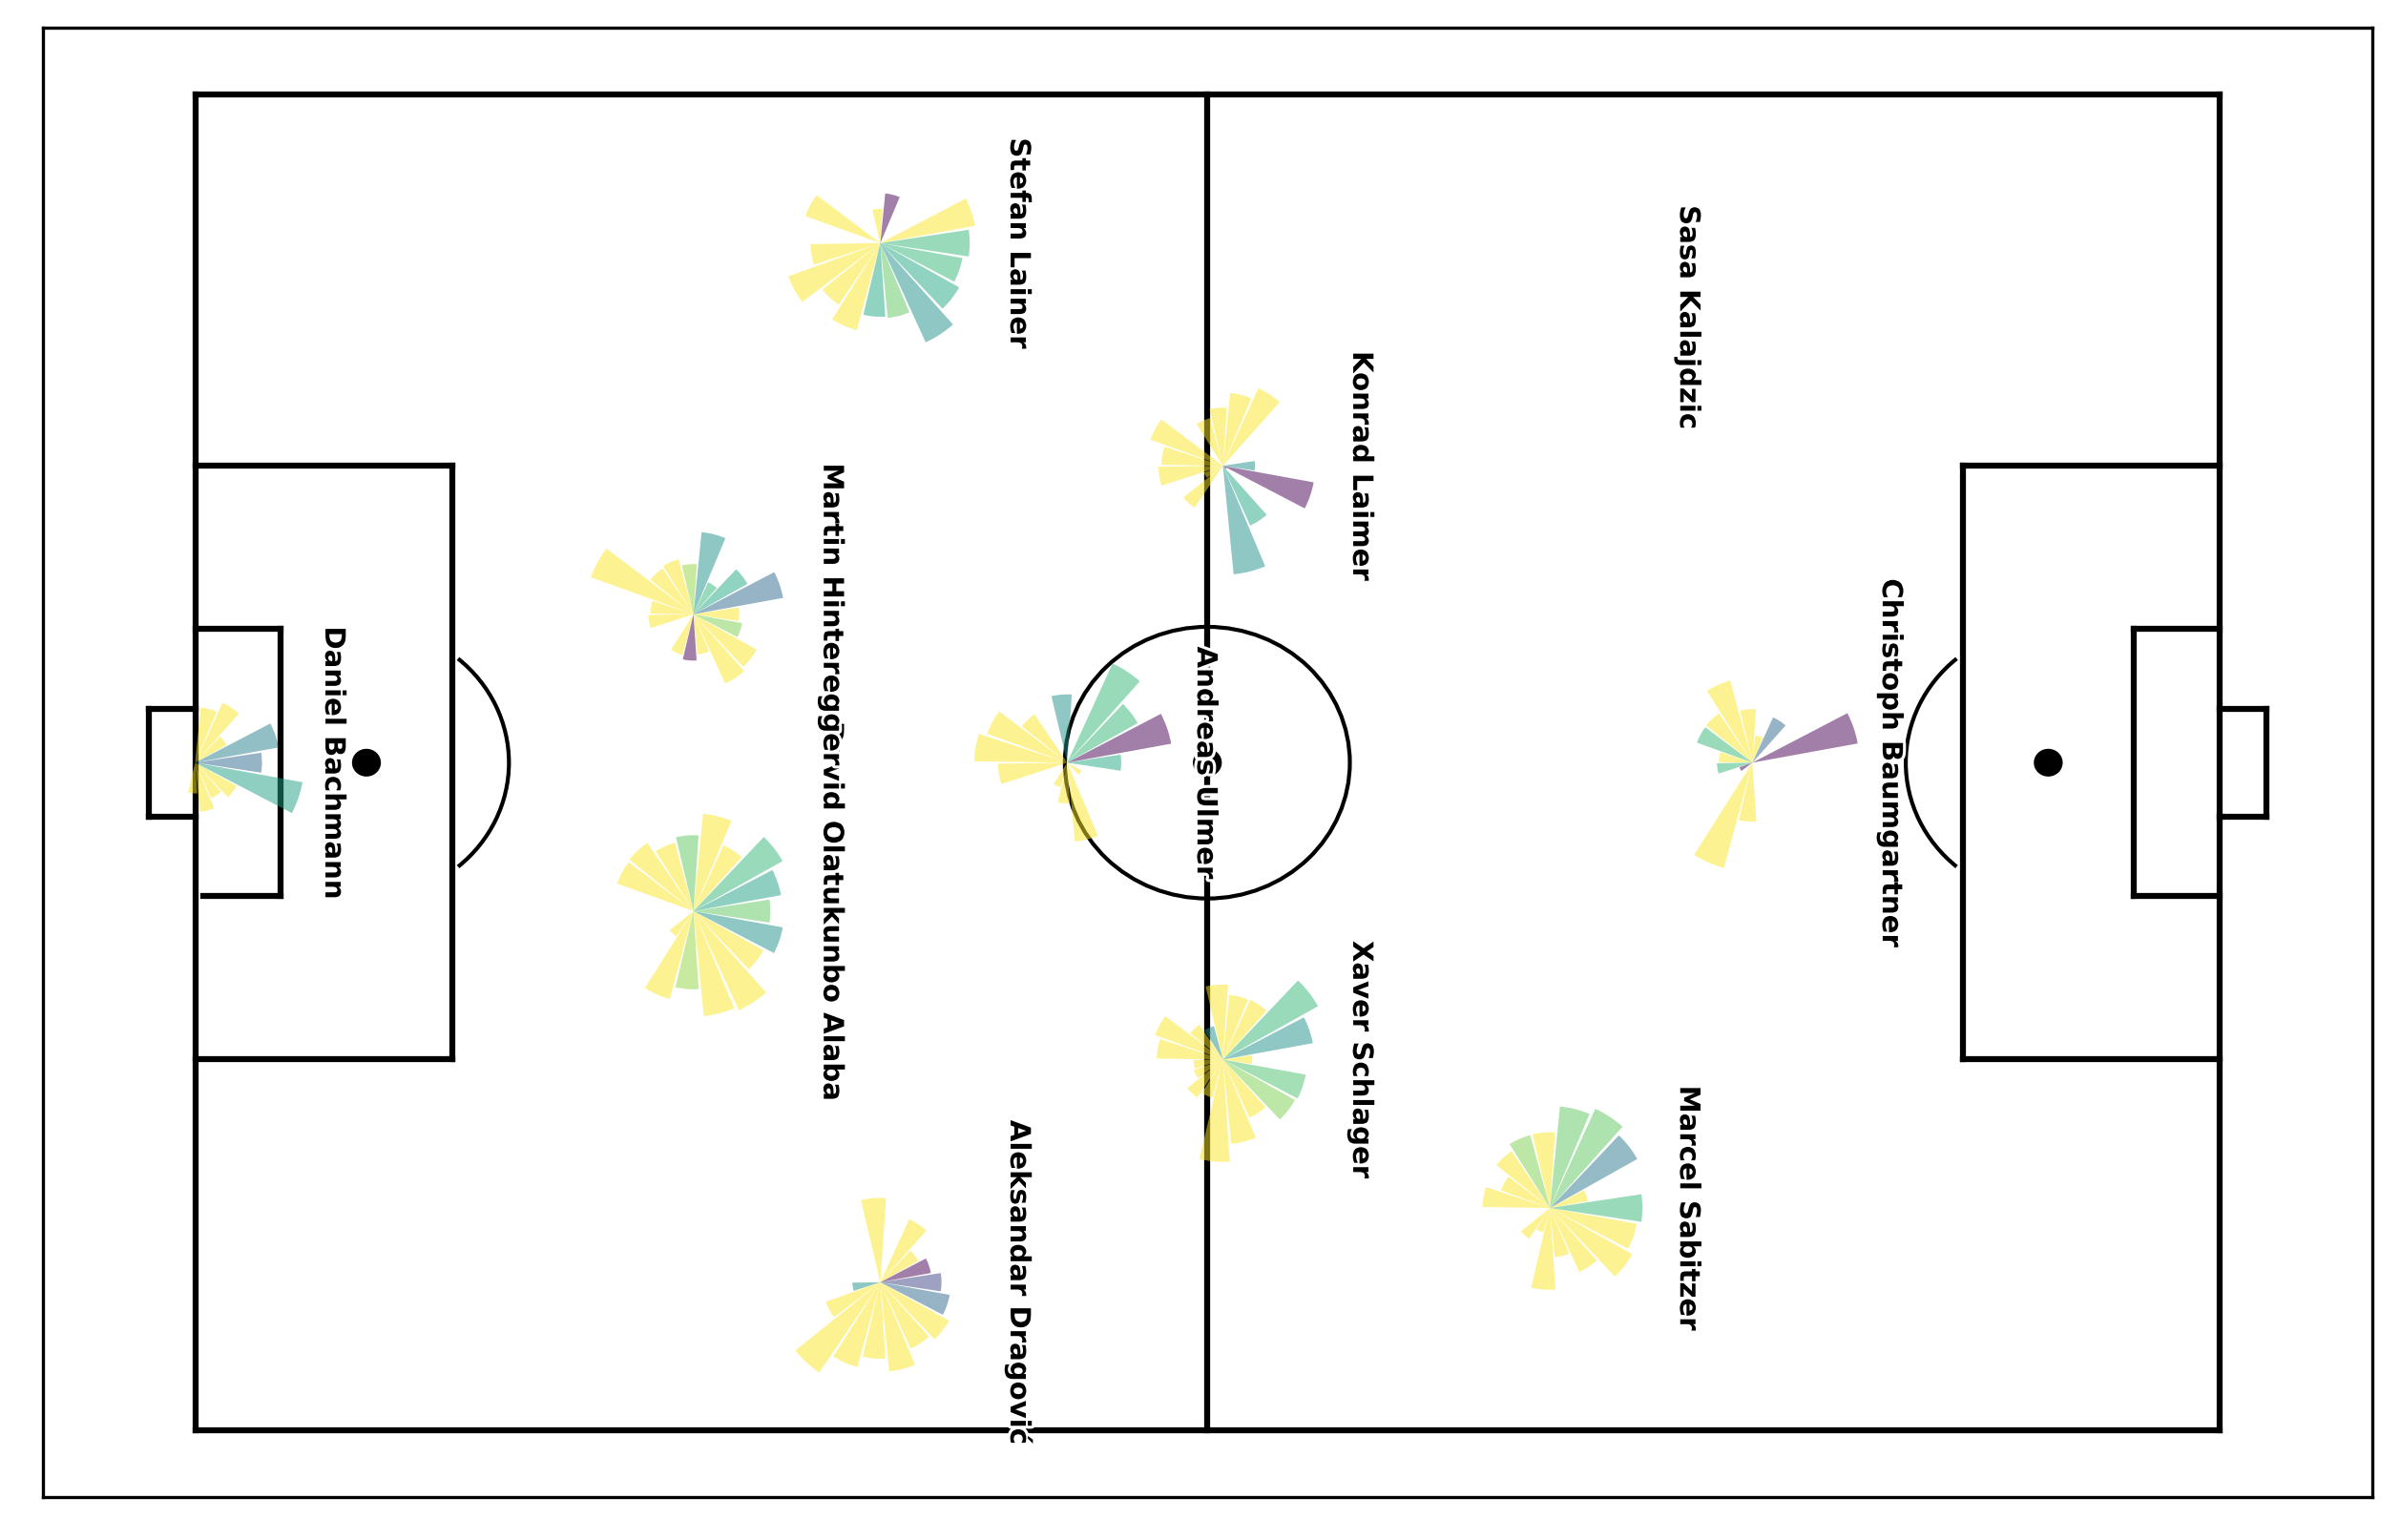

In [29]:
df = json_to_normalized_dataframe('../../data/statsbomb360/events/3788747.json')
team_dict = players_with_coordinates(df)
get_team_sonar(df, team_dict)


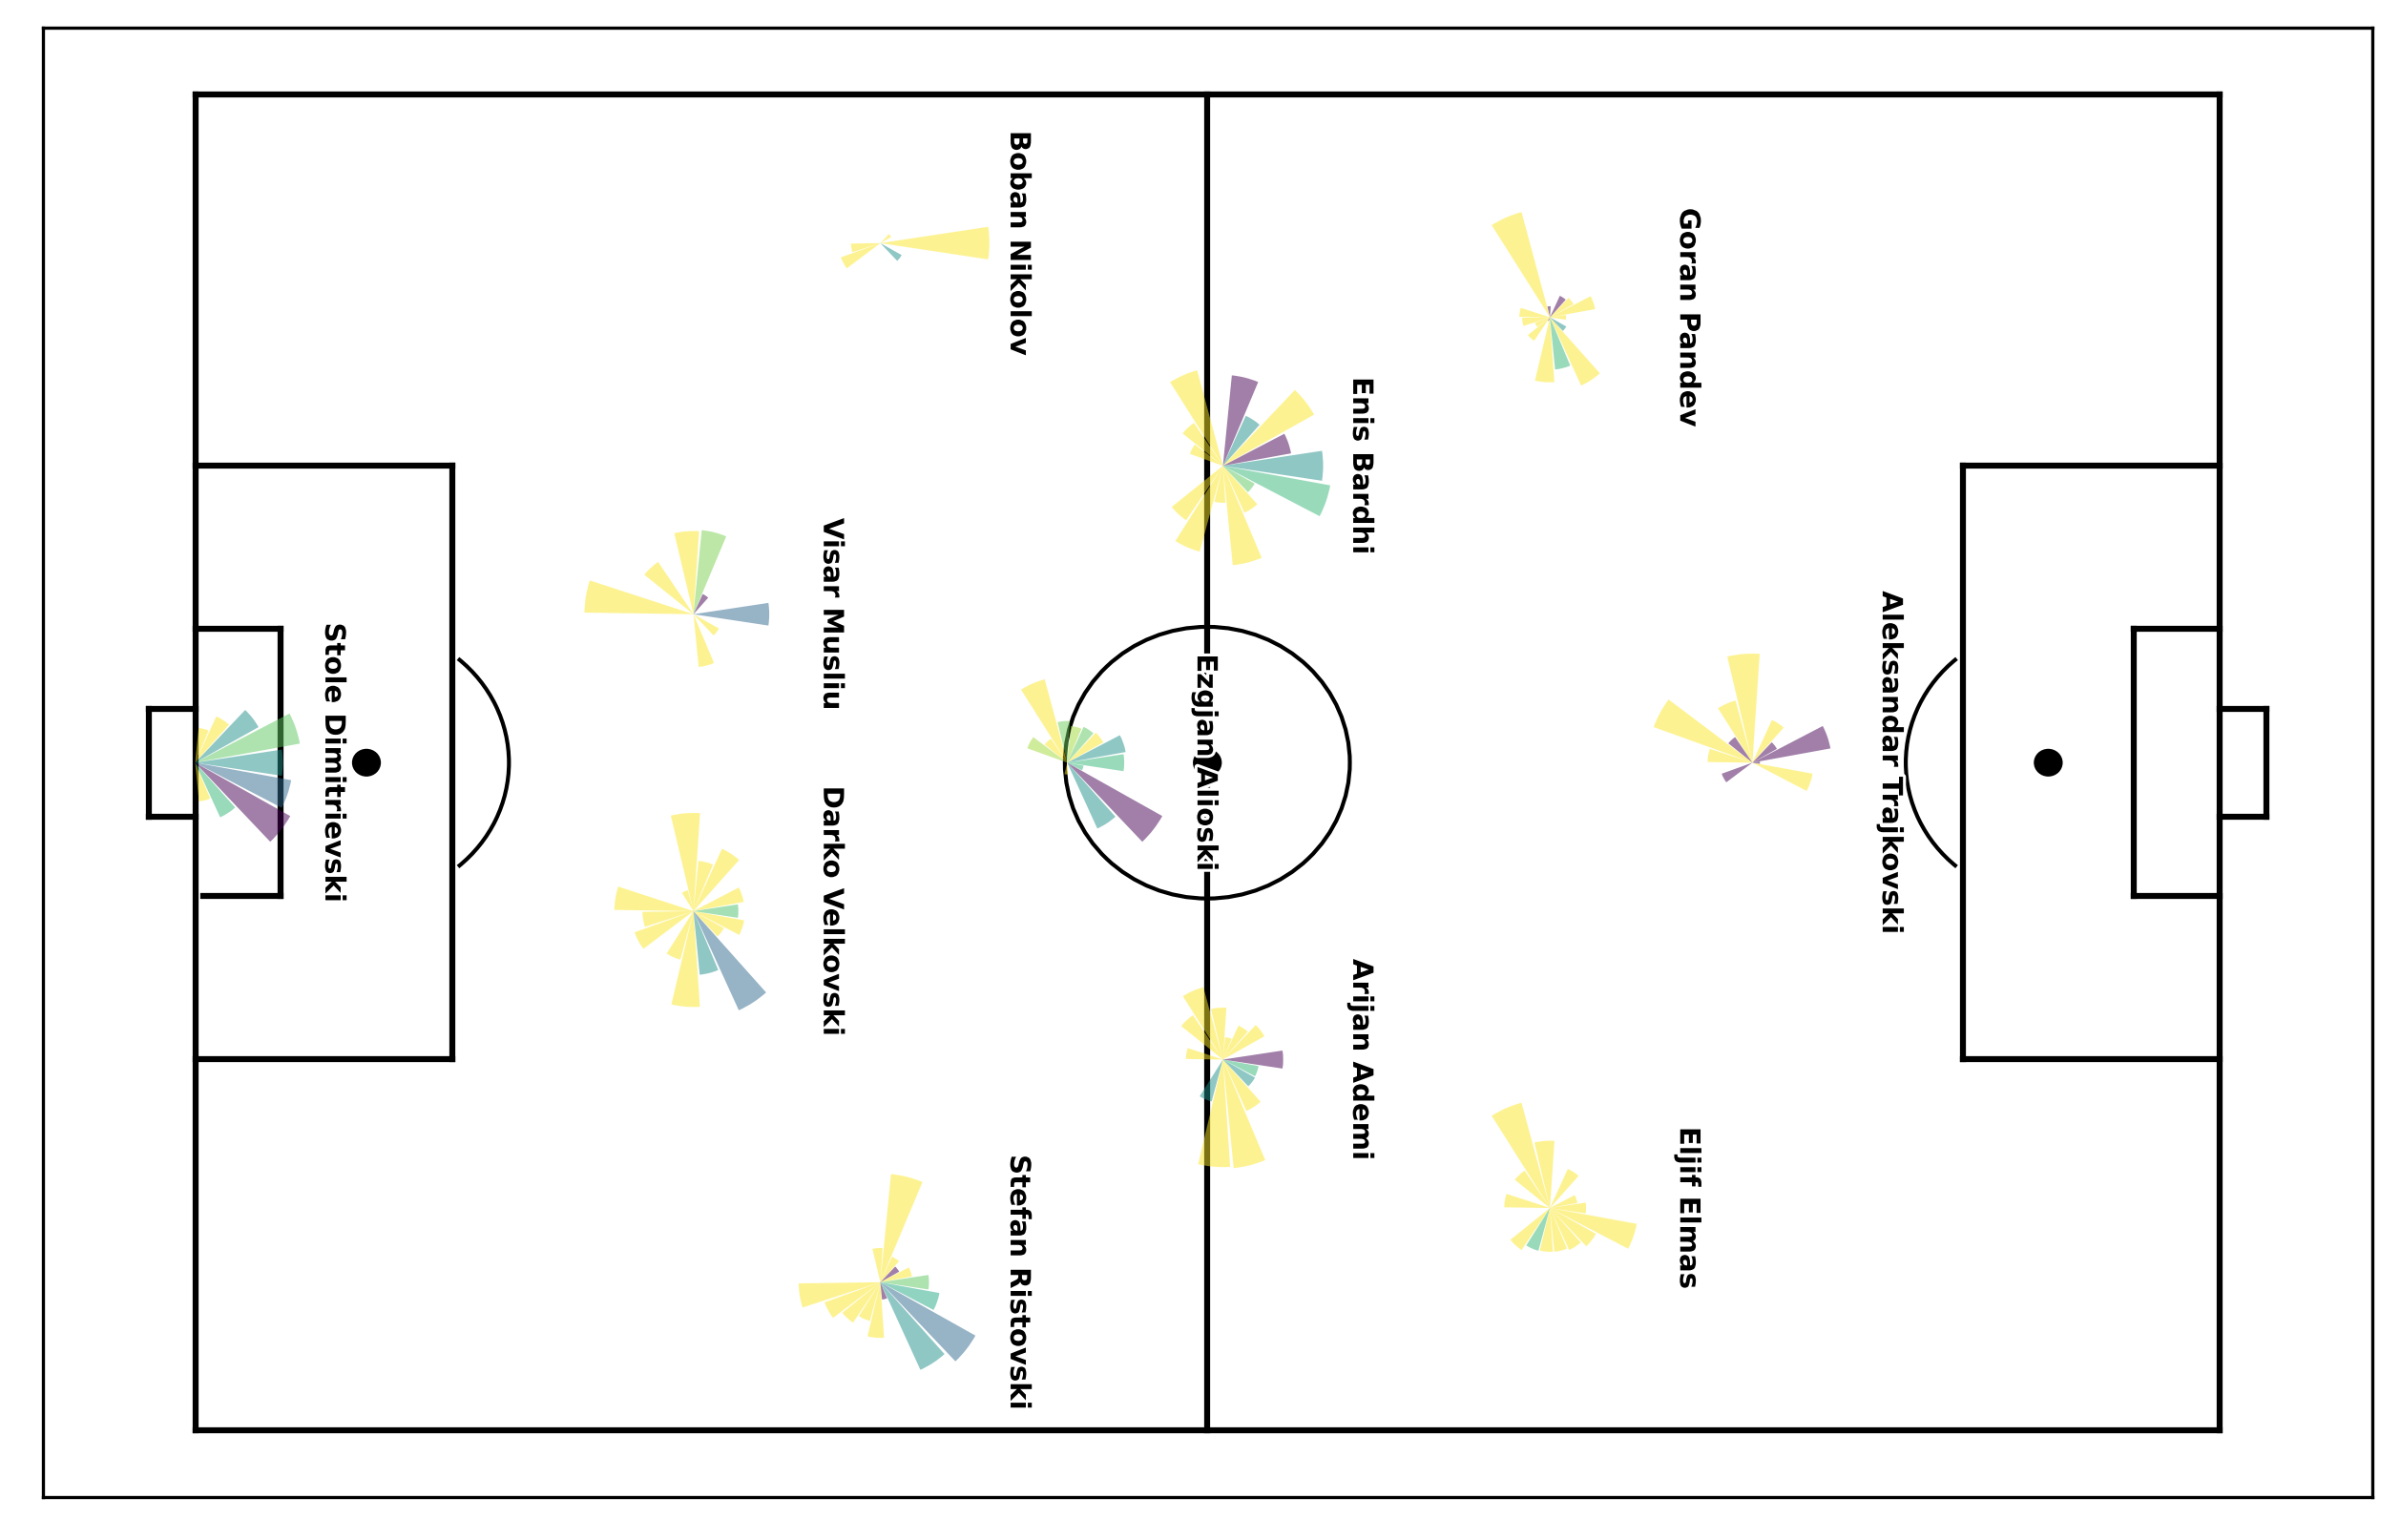

In [31]:
team_dict = players_with_coordinates(df, home_team=False)
get_team_sonar(df, team_dict, home=False)
